# Difference-in-difference: does increase in minimum wage leads to job losses? 

This notebook is a tutorial on __[difference-in-differences](https://en.wikipedia.org/wiki/Difference_in_differences)__ , a __[causal inference](https://en.wikipedia.org/wiki/Causal_inference)__ method, often used in econometrics. 

The example follows the study by Card, D., & Krueger, A. B. (1993). *Minimum wages and employment: A case study of the fast food industry in New Jersey and Pennsylvania* (Working Paper No. 4509). National Bureau of Economic Research. http://www.nber.org/papers/w4509

In April '92, New Jersey passed the law to increase the minimum wage to \$5 per hour. The economists Card and Krueger examined the effects of the law on employment. The conventional economic theory at the time was that increasing the minimum wage would lead to a higher unemployment rate, i.e., job losses.

The study examined 410 fast-food restaurants in New Jersey and Philadelphia (which didn't increase its minimum wage) before and after April '92 and used the difference-in-differences method to examine the causal relationship between minimum wages and employment. 

The study found no statistically significant employment reduction after New Jersey increased its minimum wage. 
On the contrary, it found that employment in New Jersey's fast-food sector actually increased slightly relative to Pennsylvania's, although this difference was not statistically significant. These findings have fundamentally shaped the understanding of how economic policies affect individuals and markets.

__[David Card](https://davidcard.berkeley.edu)__ was one of three recipients of the __[Nobel Prize for Economics in 2021](https://www.nobelprize.org/prizes/economic-sciences/2021/card/facts/)__ for his contributions to empirical microeconomics, especially labor economics.

## Data source for this notebook

This is the original data, as used in __[Dr. Paul C. Bauer](https://paulcbauer.github.io//)__'s course __["Applied Causal Analysis (with R)"](https://bookdown.org/paul/applied-causal-analysis/)__ at the University of Mannheim. The variable names are renamed for easier use. 

In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# read the paper one more time, to check for issue with data
# add a sentence or two below the figures

In [2]:
# load data
data = pd.read_csv("../data/data-difference-in-differences.csv")

In [3]:
# dataset statistics
data.describe()

,x_co_owned,x_southern_nj,x_central_nj,x_northeast_philadelphia,x_easton_philadelphia,x_st_wage_before,x_st_wage_after,x_hrs_open_weekday_before,x_hrs_open_weekday_after,y_ft_employment_before,y_ft_employment_after,d_nj,d_pa,x_burgerking,x_kfc,x_roys,x_wendys,x_closed_permanently
count,410.000000,410.000000,410.000000,410.000000,410.000000,390.000000,389.000000,410.000000,399.000000,398.000000,396.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000,410.000000
mean,0.343902,0.226829,0.153659,0.087805,0.104878,4.615641,4.996272,14.439024,14.465539,20.998869,21.054293,0.807317,0.192683,0.417073,0.195122,0.241463,0.146341,0.014634
std,0.475589,0.419293,0.361062,0.283357,0.306771,0.347015,0.253190,2.809987,2.752495,9.749805,9.094453,0.394888,0.394888,0.493678,0.396779,0.428493,0.353880,0.120230
min,0.000000,0.000000,0.000000,0.000000,0.000000,4.250000,4.250000,7.000000,8.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.250000,5.050000,12.000000,12.000000,14.562500,14.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,4.500000,5.050000,15.500000,15.000000,19.500000,20.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,4.950000,5.050000,16.000000,16.000000,24.500000,26.500000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.750000,6.250000,24.000000,24.000000,85.000000,60.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Variable description

```
y_ft_employment_before: Full time equivalent employment before treatment [Outcome]
y_ft_employment_after: Full time equivalent employment after treatment [Outcome]
d_nj: 1 if New Jersey; 0 if Pennsylvania (treatment variable) [Treatment]
d_pa: 1 if Pennsylvania; 0 if New Jersey (treatment variable)
x_co_owned: If owned by company = 1
x_southern_nj: If in southern NJ = 1
x_central_nj: If if in central NJ = 1
x_northeast_philadelphia: If in Pennsylvania, northeast suburbs of Philadelphia = 1
x_easton_philadelphia: If in Pennsylvania, Easton = 1
x_st_wage_before: Starting wage ($/hr) before treatment 
x_st_wage_after: Starting wage ($/hr) after treatment 
x_burgerking: If Burgerking = 1
x_kfc: If KFC = 1
x_roys: If Roys = 1
x_wendys: If Wendys = 1
x_closed_permanently: Closed permanently after treatment
```

In [4]:
# display the dataset
data

,x_co_owned,x_southern_nj,x_central_nj,x_northeast_philadelphia,x_easton_philadelphia,x_st_wage_before,x_st_wage_after,x_hrs_open_weekday_before,x_hrs_open_weekday_after,y_ft_employment_before,y_ft_employment_after,d_nj,d_pa,x_burgerking,x_kfc,x_roys,x_wendys,x_closed_permanently
0,0,0,0,1,0,NaN,4.30,16.5,16.5,40.50,24.00,0,1,1,0,0,0,0
1,0,0,0,1,0,NaN,4.45,13.0,13.0,13.75,11.50,0,1,0,1,0,0,0
2,1,0,0,1,0,NaN,5.00,10.0,11.0,8.50,10.50,0,1,0,1,0,0,0
3,1,0,0,1,0,5.00,5.25,12.0,12.0,34.00,20.00,0,1,0,0,0,1,0
4,1,0,0,1,0,5.50,4.75,12.0,12.0,24.00,35.50,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,1,0,0,0,0,4.95,5.25,12.0,11.0,9.00,23.75,1,0,0,1,0,0,0
406,1,0,0,0,0,4.75,5.25,11.0,14.0,9.75,17.50,1,0,0,1,0,0,0
407,1,0,0,0,0,4.25,5.05,19.0,18.0,24.50,20.50,1,0,0,0,1,0,0
408,0,0,0,0,0,4.75,5.05,12.5,12.5,14.00,20.50,1,0,0,0,0,1,0


In [5]:
# check for NaN values

data.isnull().any()

x_co_owned                   False
x_southern_nj                False
x_central_nj                 False
x_northeast_philadelphia     False
x_easton_philadelphia        False
x_st_wage_before              True
x_st_wage_after               True
x_hrs_open_weekday_before    False
x_hrs_open_weekday_after      True
y_ft_employment_before        True
y_ft_employment_after         True
d_nj                         False
d_pa                         False
x_burgerking                 False
x_kfc                        False
x_roys                       False
x_wendys                     False
x_closed_permanently         False
dtype: bool

In [6]:
# Interpolating NaNs

missing_values = SimpleImputer(missing_values = np.nan, 
                               strategy = 'mean')
missing_values = missing_values.fit(data[['x_st_wage_before',
                                          'x_st_wage_after', 
                                          'x_hrs_open_weekday_after', 
                                          'y_ft_employment_before',
                                          'y_ft_employment_after']])
data[['x_st_wage_before',
      'x_st_wage_after', 
      'x_hrs_open_weekday_after', 
      'y_ft_employment_before',
      'y_ft_employment_after']] = missing_values.transform(data[['x_st_wage_before',
                                                                 'x_st_wage_after', 
                                                                 'x_hrs_open_weekday_after', 
                                                                 'y_ft_employment_before',
                                                                 'y_ft_employment_after']])
data.isnull().any().sum() # check for NaNs again

0

In [7]:
# defining some variables
fte_nj_pre92 = data[data["d_nj"] == 1]["y_ft_employment_before"]
fte_nj_post92 = data[data["d_nj"] == 1]["y_ft_employment_after"]

fte_pa_pre92 = data[data["d_pa"] == 1]["y_ft_employment_before"]
fte_pa_post92 = data[data["d_pa"] == 1]["y_ft_employment_after"]

wage_nj_pre92 = data[data["d_nj"] == 1]["x_st_wage_before"]
wage_nj_post92 = data[data["d_nj"] == 1]["x_st_wage_after"]

wage_pa_pre92 = data[data["d_pa"] == 1]["x_st_wage_before"]
wage_pa_post92 = data[data["d_pa"] == 1]["x_st_wage_after"]

hrs_open_weekday_nj_pre92 = data[data["d_nj"] == 1]["x_hrs_open_weekday_before"]
hrs_open_weekday_nj_post92 = data[data["d_nj"] == 1]["x_hrs_open_weekday_after"]

hrs_open_weekday_pa_pre92 = data[data["d_pa"] == 1]["x_hrs_open_weekday_before"]
hrs_open_weekday_pa_post92 = data[data["d_pa"] == 1]["x_hrs_open_weekday_after"]

In [8]:
# dispaly statistics for FTE for New Jersey and Pennsylvania

print("FTE NJ, before 92:\nsize:", fte_nj_pre92.shape, "\nmean:", fte_nj_pre92.values.mean(), "\nmax:", fte_nj_pre92.values.max(), "\nmin:", fte_nj_pre92.values.min())
print('-----------------------------')
print("FTE NJ, after 92:\nsize:", fte_nj_post92.shape, "\nmean:", fte_nj_post92.values.mean(), "\nmax:", fte_nj_post92.values.max(), "\nmin:", fte_nj_post92.values.min())
print('-----------------------------')
print("FTE PA, before 92:\nsize:", fte_pa_pre92.shape, "\nmean:", fte_pa_pre92.values.mean(), "\nmax:", fte_pa_pre92.values.max(), "\nmin:", fte_pa_pre92.values.min())
print('-----------------------------')
print("FTE PA, after 92:\nsize:", fte_pa_post92.shape, "\nmean:", fte_pa_post92.values.mean(), "\nmax:", fte_pa_post92.values.max(), "\nmin:", fte_pa_post92.values.min())

FTE NJ, before 92:
size: (331,) 
mean: 20.45631025216718 
max: 85.0 
min: 5.0
-----------------------------
FTE NJ, after 92:
size: (331,) 
mean: 21.02840336903781 
max: 60.5 
min: 0.0
-----------------------------
FTE PA, before 92:
size: (79,) 
mean: 23.272123274600855 
max: 70.5 
min: 7.5
-----------------------------
FTE PA, after 92:
size: (79,) 
mean: 21.162766909602354 
max: 43.5 
min: 0.0


In [9]:
# dispaly wage statistics for New Jersey and Pennsylvania

print("Wages NJ, before 92:\nsize:", wage_nj_pre92.shape, "\nmean:", wage_nj_pre92.values.mean(), "\nmax:", wage_nj_pre92.values.max(), "\nmin:", wage_nj_pre92.values.min())
print('-----------------------------')
print("Wages NJ, after 92:\nsize:", wage_nj_post92.shape, "\nmean:", wage_nj_post92.values.mean(), "\nmax:", wage_nj_post92.values.max(), "\nmin:", wage_nj_post92.values.min())
print('-----------------------------')
print("Wages PA, before 92:\nsize:", wage_pa_pre92.shape, "\nmean:", wage_pa_pre92.values.mean(), "\nmax:", wage_pa_pre92.values.max(), "\nmin:", wage_pa_pre92.values.min())
print('-----------------------------')
print("Wages PA, after 92:\nsize:", wage_pa_post92.shape, "\nmean:", wage_pa_post92.values.mean(), "\nmax:", wage_pa_post92.values.max(), "\nmin:", wage_pa_post92.values.min())

Wages NJ, before 92:
size: (331,) 
mean: 4.612313889534433 
max: 5.75 
min: 4.25
-----------------------------
Wages NJ, after 92:
size: (331,) 
mean: 5.077527318478707 
max: 5.75 
min: 4.996272493573264
-----------------------------
Wages PA, before 92:
size: (79,) 
mean: 4.629581304771179 
max: 5.5 
min: 4.25
-----------------------------
Wages PA, after 92:
size: (79,) 
mean: 4.65582506264033 
max: 6.25 
min: 4.25


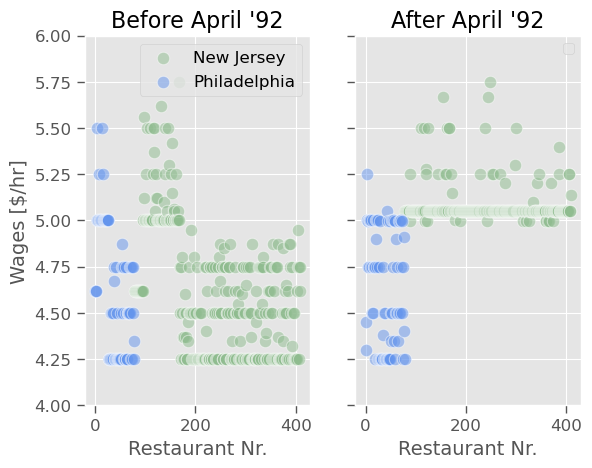

In [10]:
# simple scatter plot for wages 

# limits for y axes for both plots
max_y_up = max(max(fte_nj_pre92), max(fte_pa_pre92), max(fte_nj_post92), max(fte_nj_post92))
max_y_down = max(max(wage_nj_pre92), max(wage_pa_pre92), max(wage_nj_post92), max(wage_nj_post92))
min_y_down = min(min(wage_nj_pre92), min(wage_pa_pre92), min(wage_nj_post92), min(wage_nj_post92))

fig, axs = plt. subplots(1,2)
plt.rcParams['figure.figsize'] = [12, 6]

sns.scatterplot(wage_nj_pre92, s=80, label="New Jersey", ax=axs[0], color='darkseagreen', alpha=0.5)
sns.scatterplot(wage_pa_pre92, s=80, label="Philadelphia", ax=axs[0], color='cornflowerblue', alpha=0.5)
axs[0].set_title("Before April '92", fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
axs[0].tick_params(axis='x', bottom=True, labelbottom=True)
axs[0].tick_params(axis='y', left = True, labelleft=True)
axs[0].set_xlabel("Restaurant Nr.", fontsize=14)
axs[0].set_ylabel("Wages [$/hr]", fontsize=14)
axs[0].set_ylim(min_y_down-0.25, max_y_down+0.25)
axs[0].legend(fontsize=12)

sns.scatterplot(wage_nj_post92, s=80, label="New Jersey", ax=axs[1], color='darkseagreen', alpha=0.5)
sns.scatterplot(wage_pa_post92, s=80, label="Philadelphia", ax=axs[1], color='cornflowerblue', alpha=0.5)
axs[1].set_title("After April '92", fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=12, length=6, width=1, labelleft=False)
axs[1].tick_params(axis='x', bottom=True, labelbottom=True)
axs[1].tick_params(axis='y', left = True, labelleft=False)
axs[1].set_xlabel("Restaurant Nr.", fontsize=14)
axs[1].set_ylabel('')
axs[1].set_ylim(min_y_down-0.25, max_y_down+0.25)
axs[1].legend('')

Text(0, 0.5, '')

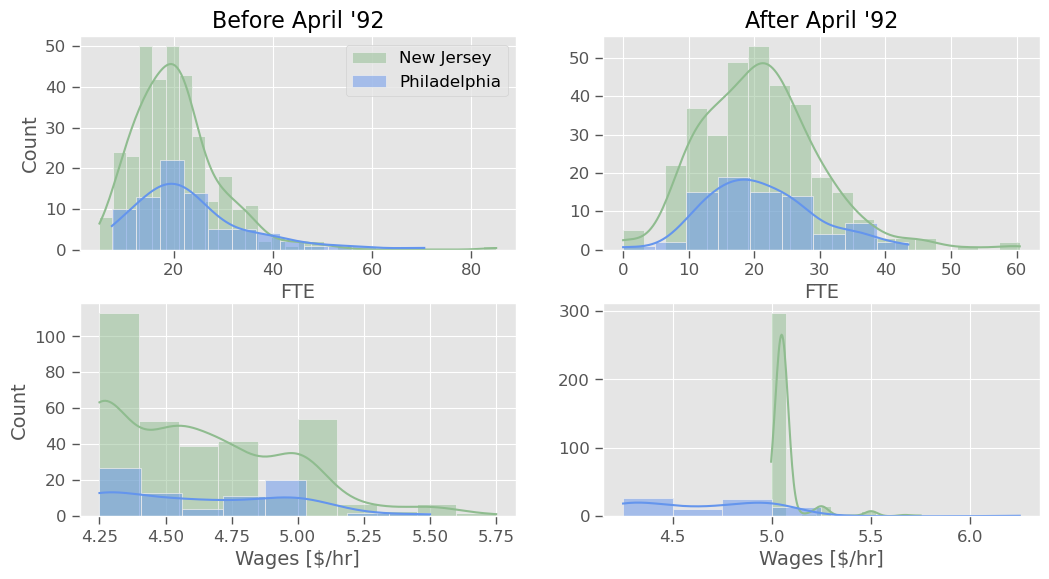

In [11]:
# plot histograms for wages and FTE

warnings.filterwarnings('ignore')

fig, axs = plt. subplots(2,2)
plt.rcParams['figure.figsize'] = [14, 10]
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.25)

sns.histplot(fte_nj_pre92, kde=True, label="New Jersey", ax=axs[0, 0], color='darkseagreen')
sns.histplot(fte_pa_pre92, kde=True, label="Philadelphia", ax=axs[0, 0], color='cornflowerblue')
axs[0,0].set_title("Before April '92", fontsize=16)
axs[0,0].tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
axs[0,0].legend(fontsize=12)
axs[0,0].tick_params(axis='x', bottom=True, labelbottom=True)
axs[0,0].tick_params(axis='y', left = True, labelleft=True)
axs[0,0].set_xlabel('FTE', fontsize=14)
axs[0,0].set_ylabel('Count', fontsize=14)

sns.histplot(fte_nj_post92, kde=True, label="New Jersey", ax=axs[0, 1], color='darkseagreen')
sns.histplot(fte_pa_post92, kde=True, label="Philadelphia", ax=axs[0, 1], color='cornflowerblue')
axs[0,1].set_title("After April '92", fontsize=16)
axs[0,1].tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
axs[0,1].tick_params(axis='x', bottom=True, labelbottom=True)
axs[0,1].tick_params(axis='y', left = True, labelleft=True)
axs[0,1].set_xlabel('FTE', fontsize=14)
axs[0,1].set_ylabel('')

sns.histplot(wage_nj_pre92, kde=True, label="New Jersey", ax=axs[1, 0], color='darkseagreen')
sns.histplot(wage_pa_pre92, kde=True, label="Philadelphia", ax=axs[1, 0], color='cornflowerblue')
axs[1,0].tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
axs[1,0].tick_params(axis='x', bottom=True, labelbottom=True)
axs[1,0].tick_params(axis='y', left = True, labelleft=True)
axs[1,0].set_xlabel('Wages [$/hr]', fontsize=14)
axs[1,0].set_ylabel('Count', fontsize=14)

sns.histplot(wage_nj_post92, kde=True, label="New Jersey", ax=axs[1, 1], color='darkseagreen')
sns.histplot(wage_pa_post92, kde=True, label="Philadelphia", ax=axs[1, 1], color='cornflowerblue')
axs[1,1].tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
axs[1,1].tick_params(axis='x', bottom=True, labelbottom=True)
axs[1,1].tick_params(axis='y', left = True, labelleft=True)
axs[1,1].set_xlabel('Wages [$/hr]', fontsize=14)
axs[1,1].set_ylabel('')

Text(37.597222222222214, 0.5, 'FTE')

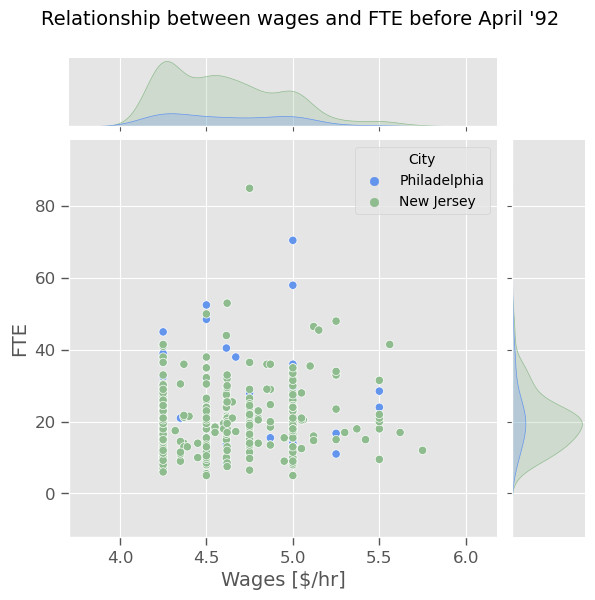

In [12]:
# plotting the relationship between FTE and wages before April '92 in a jointplot

# slicing data just for plotting
nj_mapping = {0: "Philadelphia", 1: "New Jersey"}
data_plot = data[["y_ft_employment_before", "x_st_wage_before", "d_nj"]].copy()
data_plot['d_nj'] = data_plot['d_nj'].map(nj_mapping)
data_plot = data_plot.rename(columns={'d_nj': 'City'})

# defining the color palette
palette = {"Philadelphia": 'cornflowerblue', "New Jersey": 'darkseagreen'}

sns.jointplot(data=data_plot, 
              x="x_st_wage_before", y="y_ft_employment_before", 
              kind='scatter', marginal_kws=dict(fill=True, common_norm=True), 
              hue="City", palette=palette)

plt.subplots_adjust(top=0.9) 
plt.suptitle("Relationship between wages and FTE before April '92", fontsize=14)
plt.xlabel("Wages")
plt.ylabel("FTE")
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
plt.xlabel('Wages [$/hr]', fontsize=14)
plt.ylabel('FTE', fontsize=14)

Text(37.597222222222214, 0.5, 'FTE')

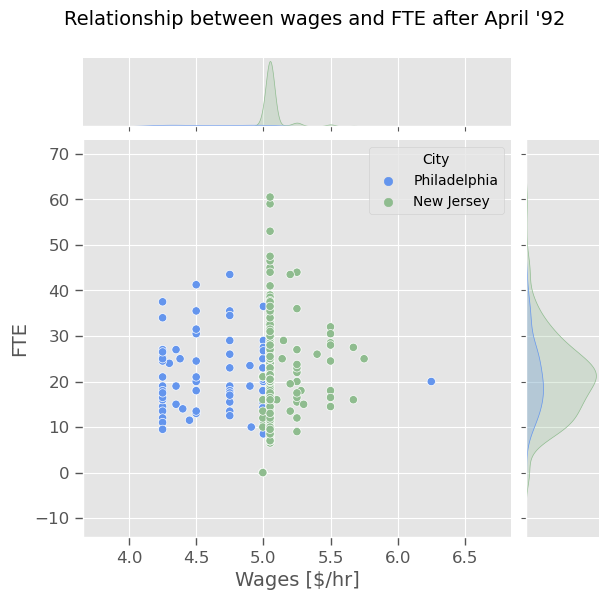

In [13]:
# plotting the relationship between FTE and wages before April '92 in a jointplot


# slicing data just for plotting
nj_mapping = {0: "Philadelphia", 1: "New Jersey"}
data_plot = data[["y_ft_employment_after", "x_st_wage_after", "d_nj"]].copy()
data_plot['d_nj'] = data_plot['d_nj'].map(nj_mapping)
data_plot = data_plot.rename(columns={'d_nj': 'City'})

# defining the color palette
palette = {"Philadelphia": 'cornflowerblue', "New Jersey": 'darkseagreen'}

sns.jointplot(data=data_plot, 
              x="x_st_wage_after", y="y_ft_employment_after", 
              kind='scatter', marginal_kws=dict(fill=True, common_norm=True), 
              hue="City", palette=palette)

plt.subplots_adjust(top=0.9) 
plt.suptitle("Relationship between wages and FTE after April '92", fontsize=14)
plt.xlabel("Wages")
plt.ylabel("FTE")
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
plt.xlabel('Wages [$/hr]', fontsize=14)
plt.ylabel('FTE', fontsize=14)

## Difference-in-differences

We are interested in difference in employment after wages increased in New Jersey, i.e. did increase in wages lead to increase in unemployment. 

In [21]:
#slicing data
X = data.loc[:,['d_nj', 'x_st_wage_before', 'x_st_wage_after']]
Y = data.loc[:,'y_ft_employment_after'] - data.loc[:,'y_ft_employment_before']  # differences in fte/employment

### Model 1

This is the simplest model. We are only looking at wages and the treatmen variable, i.e. binary variable for New Jersey.

In [14]:
# model 1
X = sm.add_constant(X)
model1 = sm.OLS(Y, X).fit()
model1.summary(yname = "FTE", 
               xname = ("Intercept", "New Jersey", "Wages before", "Wages after"))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FTE   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.771
Date:                Wed, 26 Jun 2024   Prob (F-statistic):             0.0413
Time:                        16:21:23   Log-Likelihood:                -1470.5
No. Observations:                 410   AIC:                             2949.
Df Residuals:                     406   BIC:                             2965.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.2798     11.705      0.366      0.715     -18.730      27.290
New Jersey       2.3776      1.512      1.572      0.117      -0.595       5.350
Wages before    -2.0216      1.317     -1.535      0.125      -4.610       0.567
Wages after      0.6379      2.449      0.260      0.795      -4.177       5.453
==============================================================================
Omnibus:                       36.089   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.712
Skew:                          -0.370   Prob(JB):                     1.11e-23
Kurtosis:                       5.375   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 2

Here we account for different fast-food chains.

In [22]:
# model 2
X = data.loc[:,['d_nj', 'x_st_wage_before', 'x_st_wage_after',
                'x_burgerking', 'x_kfc', 'x_wendys']]      # defining X; Y stays the same
X = sm.add_constant(X)

model2 = sm.OLS(Y, X).fit()
model2.summary(yname = "FTE", 
               xname = ("Intercept", "New Jersey", "Wages before", "Wages after", 
                       'Burger King', 'KFC', 'Wendys'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FTE   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.354
Date:                Wed, 26 Jun 2024   Prob (F-statistic):             0.0302
Time:                        16:24:41   Log-Likelihood:                -1467.6
No. Observations:                 410   AIC:                             2949.
Df Residuals:                     403   BIC:                             2977.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.2431     11.872      0.189      0.850     -21.095      25.581
New Jersey       2.5855      1.516      1.706      0.089      -0.394       5.565
Wages before    -1.6649      1.348     -1.235      0.218      -4.315       0.985
Wages after      0.3163      2.450      0.129      0.897      -4.500       5.133
Burger King      2.2520      1.125      2.003      0.046       0.041       4.463
KFC              2.6647      1.322      2.015      0.045       0.065       5.264
Wendys           2.5290      1.441      1.755      0.080      -0.305       5.363
==============================================================================
Omnibus:                       41.224   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.734
Skew:                          -0.436   Prob(JB):                     2.23e-27
Kurtosis:                       5.535   Cond. No.                         194.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 3

Here we add the co-ownership variable.

In [23]:
# model 3
X = data.loc[:,['d_nj', 'x_st_wage_before', 'x_st_wage_after',
                'x_burgerking', 'x_kfc', 'x_wendys', 'x_co_owned']]      # defining X; Y stays the same
X = sm.add_constant(X)

model3 = sm.OLS(Y, X).fit()
model3.summary(yname = "FTE", 
               xname = ("Intercept", "New Jersey", "Wages before", "Wages after", 
                       'Burger King', 'KFC', 'Wendys', 'Co-owned'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FTE   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.049
Date:                Wed, 26 Jun 2024   Prob (F-statistic):             0.0480
Time:                        16:25:42   Log-Likelihood:                -1467.5
No. Observations:                 410   AIC:                             2951.
Df Residuals:                     402   BIC:                             2983.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.6780     11.915      0.225      0.822     -20.745      26.101
New Jersey       2.6635      1.525      1.747      0.081      -0.334       5.662
Wages before    -1.7075      1.352     -1.263      0.207      -4.366       0.951
Wages after      0.1850      2.467      0.075      0.940      -4.664       5.034
Burger King      2.5260      1.253      2.016      0.044       0.063       4.989
KFC              2.7841      1.345      2.070      0.039       0.140       5.428
Wendys           2.7934      1.537      1.817      0.070      -0.229       5.816
Co-owned         0.5191      1.043      0.498      0.619      -1.531       2.569
==============================================================================
Omnibus:                       40.587   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.915
Skew:                          -0.427   Prob(JB):                     5.54e-27
Kurtosis:                       5.520   Cond. No.                         195.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 4

Here we add variables to account for regional differences within New Jersey.

In [17]:
# model 4
X = data.loc[:,['d_nj', 'x_st_wage_before', 'x_st_wage_after',
                'x_burgerking', 'x_kfc', 'x_wendys', 'x_co_owned', 
                'x_southern_nj', 'x_central_nj']]      # defining X; Y stays the same
X = sm.add_constant(X)

model4 = sm.OLS(Y, X).fit()
model4.summary(yname = "FTE", 
               xname = ("Intercept", "New Jersey", "Wages before", "Wages after", 
                       'Burger King', 'KFC', 'Wendys', 'Co-owned', 'Southern NJ', 'Central NJ'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FTE   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.657
Date:                Wed, 26 Jun 2024   Prob (F-statistic):             0.0974
Time:                        16:21:23   Log-Likelihood:                -1467.1
No. Observations:                 410   AIC:                             2954.
Df Residuals:                     400   BIC:                             2994.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.6321     11.975      0.220      0.826     -20.909      26.173
New Jersey       2.9380      1.595      1.842      0.066      -0.198       6.074
Wages before    -1.7055      1.362     -1.252      0.211      -4.384       0.973
Wages after      0.2137      2.472      0.086      0.931      -4.647       5.074
Burger King      2.4209      1.263      1.917      0.056      -0.062       4.904
KFC              2.7804      1.356      2.050      0.041       0.114       5.447
Wendys           2.7189      1.545      1.760      0.079      -0.318       5.756
Co-owned         0.4189      1.064      0.394      0.694      -1.672       2.510
Southern NJ     -0.3599      1.148     -0.313      0.754      -2.618       1.898
Central NJ      -1.0189      1.305     -0.781      0.435      -3.584       1.546
==============================================================================
Omnibus:                       39.994   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.224
Skew:                          -0.425   Prob(JB):                     3.51e-26
Kurtosis:                       5.478   Cond. No.                         196.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 5

Here we removed regional differences for New Jersey, but add a variable for permanently closed restaurants.

In [18]:
# model 5
X = data.loc[:,['d_nj', 'x_st_wage_before', 'x_st_wage_after',
                'x_burgerking', 'x_kfc', 'x_wendys', 'x_co_owned', 
                'x_closed_permanently']]      # defining X; Y stays the same
X = sm.add_constant(X)

model5 = sm.OLS(Y, X).fit()
model5.summary(yname = "FTE", 
               xname = ("Intercept", "New Jersey", "Wages before", "Wages after", 
                       'Burger King', 'KFC', 'Wendys', 'Co-owned', 'Permanently closed'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FTE   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     3.371
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           0.000935
Time:                        16:21:23   Log-Likelihood:                -1461.3
No. Observations:                 410   AIC:                             2941.
Df Residuals:                     401   BIC:                             2977.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.0758     11.759      0.347      0.729     -19.041      27.192
New Jersey             2.6509      1.504      1.762      0.079      -0.306       5.608
Wages before          -2.0341      1.337     -1.521      0.129      -4.662       0.594
Wages after            0.2752      2.433      0.113      0.910      -4.508       5.058
Burger King            2.3748      1.237      1.920      0.056      -0.056       4.806
KFC                    2.3981      1.331      1.801      0.072      -0.219       5.015
Wendys                 2.4822      1.519      1.634      0.103      -0.504       5.468
Co-owned               0.6248      1.029      0.607      0.544      -1.398       2.648
Permanently closed   -12.5167      3.580     -3.496      0.001     -19.554      -5.479
==============================================================================
Omnibus:                       45.365   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.781
Skew:                          -0.456   Prob(JB):                     4.93e-33
Kurtosis:                       5.807   Cond. No.                         195.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model 6

Here we removed a variable for permanently closed restaurants, but added variables for opening hours.

In [19]:
# model 6
X = data.loc[:,['d_nj', 'x_st_wage_before', 'x_st_wage_after',
                'x_burgerking', 'x_kfc', 'x_wendys', 'x_co_owned', 
                'x_hrs_open_weekday_before', 'x_hrs_open_weekday_after']]      # defining X; Y stays the same
X = sm.add_constant(X)

model6 = sm.OLS(Y, X).fit()
model6.summary(yname = "FTE", 
               xname = ("Intercept", "New Jersey", "Wages before", "Wages after", 
                       'Burger King', 'KFC', 'Wendys', 'Co-owned', 
                        'Hours open weekday before', 'Hours open weekday after'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    FTE   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.078
Date:                Wed, 26 Jun 2024   Prob (F-statistic):             0.0304
Time:                        16:21:23   Log-Likelihood:                -1465.3
No. Observations:                 410   AIC:                             2951.
Df Residuals:                     400   BIC:                             2991.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.1487     12.391      0.173      0.862     -22.211      26.508
New Jersey                    2.6472      1.522      1.739      0.083      -0.346       5.640
Wages before                 -1.7194      1.349     -1.275      0.203      -4.371       0.932
Wages after                   0.4711      2.465      0.191      0.849      -4.376       5.318
Burger King                   2.1819      1.262      1.729      0.084      -0.298       4.662
KFC                           2.0479      1.876      1.092      0.276      -1.639       5.735
Wendys                        2.2897      1.812      1.263      0.207      -1.273       5.853
Co-owned                      0.5392      1.040      0.518      0.604      -1.506       2.584
Hours open weekday before    -0.9002      0.450     -2.002      0.046      -1.784      -0.016
Hours open weekday after      0.8655      0.444      1.951      0.052      -0.006       1.737
==============================================================================
Omnibus:                       43.492   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.363
Skew:                          -0.458   Prob(JB):                     1.81e-29
Kurtosis:                       5.628   Cond. No.                         639.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Conclusion

In all 6 models, treatment variable is not statistically significant, i.e. p-value is larger than 0.05.
This means that we cant conclude that the explanatory variable affects the dependent variable, 
or in our case the increase in wages doesn't effect differences in employment.